In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stats import get_stats
df_full = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar_v2.parq')

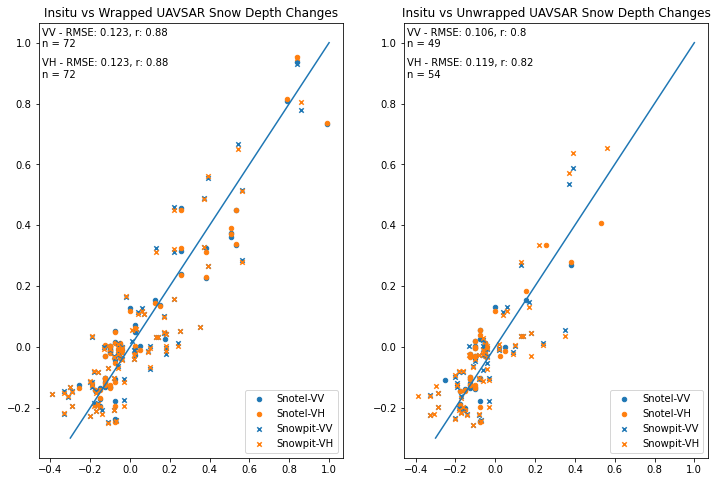

In [441]:
fig, axes = plt.subplots(1, 2, figsize = (12,8))

symbol_dic = {'NRCS':'o', 'SnowEx':'x'}

for source in ['NRCS', 'SnowEx']:
    df = df_full.loc[df_full.datasource == source]
    symbol = symbol_dic[source]

    for j, img_type in enumerate(['int', 'unw']):
        for i, band in enumerate(['VV', 'VH']):
            if source == 'NRCS':
                df.plot.scatter(x = 'dSD', y = f'UV_{img_type}_{band}_sd', ax = axes[j], label = f'Snotel-{band}', marker = symbol, color = f'C{i}')
            else:
                df.plot.scatter(x = 'dSD', y = f'UV_{img_type}_{band}_sd', ax = axes[j], label = f'Snowpit-{band}', marker = symbol, color = f'C{i}')

axes[0].set_title('Insitu vs Wrapped UAVSAR Snow Depth Changes')
axes[0].set_xlabel('Insitu')
axes[0].set_ylabel('Wrapped UAVSAR SD')
axes[0].legend(loc = 'lower right')


axes[1].set_title('Insitu vs Unwrapped UAVSAR Snow Depth Changes')
axes[1].set_xlabel('Insitu')
axes[1].set_ylabel('Unwrapped UAVSAR SD')
axes[1].legend(loc = 'lower right')

# add RMSE, R, N to fig
rmse, r, n = get_stats(df.dSD.values.ravel(), df.UV_int_VV_sd.values.ravel())
axes[0].text(.01, .99, f'VV - RMSE: {rmse:.3}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[0].transAxes)
rmse, r, n = get_stats(df.dSD.values.ravel(), df.UV_int_VH_sd.values.ravel())
axes[0].text(.01, .92, f'VH - RMSE: {rmse:.3}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[0].transAxes)

rmse, r, n = get_stats(df.dSD.values.ravel(), df.UV_unw_VV_sd.values.ravel())
axes[1].text(.01, .99, f'VV - RMSE: {rmse:.3}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[1].transAxes)
rmse, r, n = get_stats(df.dSD.values.ravel(), df.UV_unw_VH_sd.values.ravel())
axes[1].text(.01, .92, f'VH - RMSE: {rmse:.3}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[1].transAxes)

for ax in axes.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.plot([-0.3,1], [-0.3, 1], label = '1-to-1')

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/insitu/insitu_uavsar_scatterv2.png')

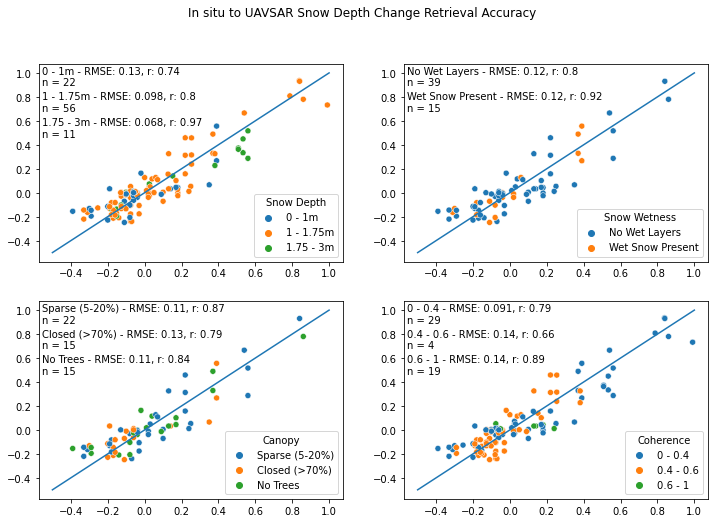

In [438]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize = (12,8))

symbol_dic = {'NRCS':'o', 'SnowEx':'x'}

df = df_full.loc[df_full.datasource == 'SnowEx']

## SNOW DEPTH ##
df_full['sd_class'] = pd.cut(df_full.SD, [0, 1, 1.75, 3] )
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'sd_class', data = df_full, ax = axes[0,0])

L=axes[0,0].legend()
L.get_texts()[0].set_text('0 - 1m')
L.get_texts()[1].set_text('1 - 1.75m')
L.get_texts()[2].set_text('1.75 - 3m')
sns.move_legend(axes[0,0], 'lower right', title = 'Snow Depth')

labels = {'(0.0, 1.0]':'0 - 1m', '(1.0, 1.75]':'1 - 1.75m', '(1.75, 3.0]':'1.75 - 3m'}
for i, c in enumerate(sorted(df_full.sd_class.unique())):
    name = labels[str(c)]
    rmse, r, n = get_stats(df_full[df_full.sd_class == c].dSD.values.ravel(), df_full[df_full.sd_class == c].UV_unw_VH_sd.values.ravel())
    axes[0,0].text(.01, .99 - i*0.13, f'{name} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[0,0].transAxes)

## SNOW WETNESS ##
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'any_wet', data = df, ax = axes[0, 1])

L=axes[0,1].legend()
L.get_texts()[0].set_text('No Wet Layers')
L.get_texts()[1].set_text('Wet Snow Present')
sns.move_legend(axes[0,1], 'lower right', title = 'Snow Wetness')

labels = {0.0:'No Wet Layers', 1.0:'Wet Snow Present'}
for i, c in enumerate(df.any_wet.unique()):
    name = labels[c]
    rmse, r, n = get_stats(df[df.any_wet == c].dSD.values.ravel(), df[df.any_wet == c].UV_unw_VH_sd.values.ravel())
    axes[0, 1].text(.01, .99 - i*0.13, f'{name} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[0,1].transAxes)

## CANOPY ##
# remove open as n = 2
df = df[df.canopy != 'Open (20-70%)']
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'canopy', data = df[df.canopy != 'Open (20-70%)'], ax = axes[1, 0])
sns.move_legend(axes[1, 0], title='Canopy', loc='lower right')

for i, c in enumerate(df[df.canopy != 'Open (20-70%)'].canopy.unique()):
    rmse, r, n = get_stats(df[df.canopy == c].dSD.values.ravel(), df[df.canopy == c].UV_unw_VH_sd.values.ravel())
    axes[1, 0].text(.01, .99 - i*0.13, f'{c} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[1,0].transAxes)

## COHERENCE ##
df_full['cor_class'] = pd.cut(df_full.VV_cor, [0.2,0.4, 0.6, 0.8] )
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'cor_class', data = df_full, ax = axes[1, 1])

L=axes[1,1].legend()
L.get_texts()[0].set_text('0 - 0.4')
L.get_texts()[1].set_text('0.4 - 0.6')
L.get_texts()[2].set_text('0.6 - 1')
sns.move_legend(axes[1,1], 'lower right', title = 'Coherence')

labels = {'(0.4, 0.6]':'0 - 0.4','(0.6, 0.8]': '0.4 - 0.6','(0.2, 0.4]': '0.6 - 1'}
for i, c in enumerate(df.cor_class.unique()):
    name = labels[str(c)]
    rmse, r, n = get_stats(df[df.cor_class == c].dSD.values.ravel(), df[df.cor_class == c].UV_unw_VH_sd.values.ravel())
    axes[1, 1].text(.01, .99 - i*0.13, f'{name} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[1,1].transAxes)

for ax in axes.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.plot([-0.5,1], [-0.5, 1], label = '1-to-1')

plt.suptitle('In situ to UAVSAR Snow Depth Change Retrieval Accuracy')
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/insitu/insitu_binned_scatter.png')